<a href="https://colab.research.google.com/github/LeoFernanndes/notebooks/blob/master/titanic_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Titanic Kaggle

## Standard Classifier

In [0]:
import pandas as pd


url = 'https://raw.githubusercontent.com/LeoFernanndes/datasets/master/titanic_%20train.csv' 
titanic_df = pd.read_csv(url)

columns_order = ['PassengerId', 'Name', 'Fare', 'Sex', 'Age', 'Pclass', 'SibSp', 'Parch', 'Embarked', 'Cabin', 'Ticket', 'Survived']
titanic = titanic_df.reindex(columns_order, axis= 1)

colunas = ['Fare', 'Sex', 'Age', 'Pclass', 'SibSp']
colunas_ = ['PassengerId', 'Name', 'Fare', 'Sex', 'Age', 'Pclass', 'SibSp', 'Parch', 'Embarked', 'Cabin', 'Ticket', 'Survived']

In [0]:


def value_y(valor):
  if valor < 20:
    return 1
  else:
    return 0

def value_m(valor):
  if (valor >=20 and valor <=50):
    return 1
  else:
    return 0


def value_e(valor):
  if valor > 50:
    return 1
  else:
    return 0

def fare_bin(valor):
  if valor < 7:
    return 1
  elif (valor >= 7 and valor < 14):
    return 2
  elif (valor >= 14 and valor < 31):
    return 3
  else:
    return 4

def pclass(valor):
  if valor == 1:
    return 6
  elif valor == 2:
    return 5
  else:
    return 4

In [0]:
# filling in the gaps

for column in titanic.columns:
  if titanic[column].dtype != 'object':
      titanic[column].fillna(titanic[column].mean(), inplace= True)
  else:
      titanic[column] = titanic[column].astype('str')
      titanic[column].fillna(titanic[column].mode(), inplace= True)


from sklearn.preprocessing import LabelEncoder


le = LabelEncoder()
for column in titanic.columns:
  if titanic[column].dtype == 'object':
    titanic[column] = le.fit_transform(titanic[column])




titanic['Sex_m'] = titanic_df['Sex'].map({'male': 1, 'female': 0})
titanic['Sex_f'] = titanic_df['Sex'].map({'male': 0, 'female': 1})

titanic['Age_y'] = titanic_df['Age'].apply(value_y)
titanic['Age_m'] = titanic_df['Age'].apply(value_m)
titanic['Age_e'] = titanic_df['Age'].apply(value_e)

titanic['Fare'] = titanic_df['Fare'].apply(fare_bin)

titanic['Pclass'] = titanic_df['Pclass'].apply(pclass)

titanic['n_family'] = titanic['Parch'] + titanic['SibSp']

colunas = ['Sex_f', 'Pclass', 'Fare',  'Sex_m', 'Age_y', 'Parch', 'Age_m', 'Age_e', 'SibSp',
       'Embarked', 'Cabin', 'Ticket']
colunas_ = ['Fare',  'Sex_m', 'Sex_f', 'Age_y', 'Age_m', 'Age_e', 'Pclass', 'SibSp', 'Parch',
       'Embarked', 'Cabin', 'Ticket', 'Survived']

'''

titanic['Fare'] = titanic_df['Fare'].apply(fare_bin)
titanic['Pclass'] = titanic_df['Pclass'].apply(pclass)
titanic['n_family'] = titanic['Parch'] + titanic['SibSp']

'''

titanic_train = titanic.iloc[0: 600]
titanic_test = titanic.iloc[600: ]

x_train = titanic_train[colunas]
y_train = titanic_train['Survived']

x_test = titanic_test[colunas]
y_test = titanic_test['Survived']

In [17]:
titanic[colunas_].corr()

,Fare,Sex_m,Sex_f,Age_y,Age_m,Age_e,Pclass,SibSp,Parch,Embarked,Cabin,Ticket,Survived
Fare,1.000000,-0.245171,0.245171,0.076167,-0.027425,0.120167,0.599582,0.398397,0.390771,-0.173460,-0.479301,-0.138390,0.289705
Sex_m,-0.245171,1.000000,-1.000000,-0.104297,0.010723,0.050538,-0.131900,-0.114631,-0.245489,0.104057,0.096681,0.059372,-0.543351
Sex_f,0.245171,-1.000000,1.000000,0.104297,-0.010723,-0.050538,0.131900,0.114631,0.245489,-0.104057,-0.096681,-0.059372,0.543351
Age_y,0.076167,-0.104297,0.104297,1.000000,-0.520290,-0.132127,-0.126098,0.255485,0.260339,0.027910,0.060889,-0.008637,0.095582
Age_m,-0.027425,0.010723,-0.010723,-0.520290,1.000000,-0.304739,0.105201,-0.178299,-0.088007,0.108420,-0.034973,0.036887,0.011376
Age_e,0.120167,0.050538,-0.050538,-0.132127,-0.304739,1.000000,0.253606,-0.068910,-0.029255,-0.013570,-0.194567,-0.106445,-0.022932
Pclass,0.599582,-0.131900,0.131900,-0.126098,0.105201,0.253606,1.000000,-0.083081,-0.018443,-0.157112,-0.684121,-0.319869,0.338481
SibSp,0.398397,-0.114631,0.114631,0.255485,-0.178299,-0.068910,-0.083081,1.000000,0.414838,0.066654,0.043593,0.079461,-0.035322
Parch,0.390771,-0.245489,0.245489,0.260339,-0.088007,-0.029255,-0.018443,0.414838,1.000000,0.038322,-0.028324,0.020003,0.081629
Embarked,-0.173460,0.104057,-0.104057,0.027910,0.108420,-0.013570,-0.157112,0.066654,0.038322,1.000000,0.193205,-0.006041,-0.163517


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform') 

 0.7972508591065293 0.6597938144329898 0.6878306878306878 0.5520361990950227 




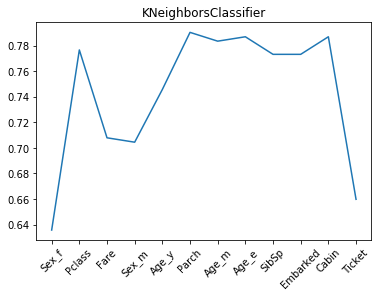

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1) 

 0.8178694158075601 0.838487972508591 0.7225130890052355 0.758974358974359 




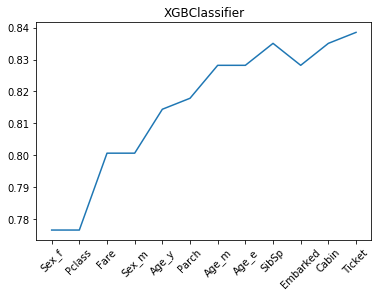

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False) 

 0.8006872852233677 0.7903780068728522 0.6979166666666666 0.6903553299492386 




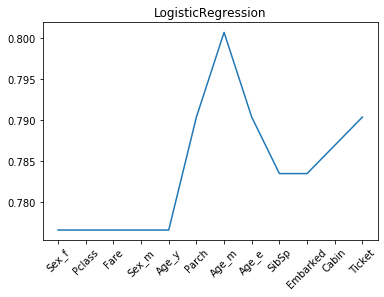

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False) 

 0.7938144329896907 0.7883161512027491 0.6907216494845361 0.6859903381642511 




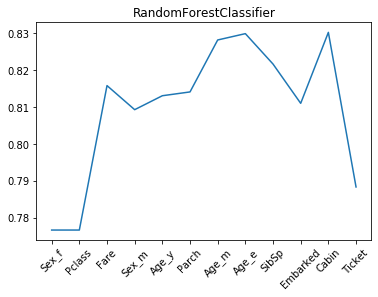

GaussianNB(priors=None, var_smoothing=1e-09) 

 0.7938144329896907 0.7835051546391752 0.6907216494845361 0.7096774193548386 




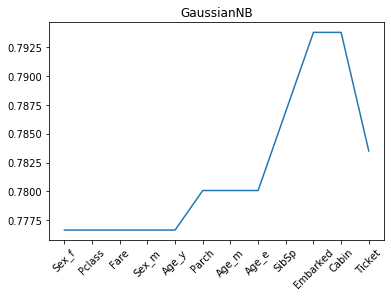

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False) 

 0.7938144329896907 0.6941580756013747 0.6907216494845361 0.5082872928176795 




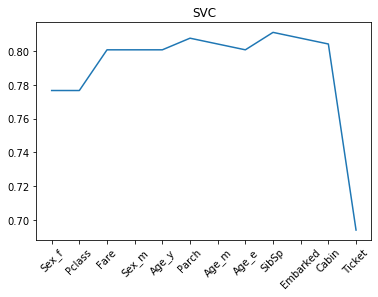

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001) 

 0.7903780068728522 0.7835051546391752 0.6839378238341969 0.676923076923077 




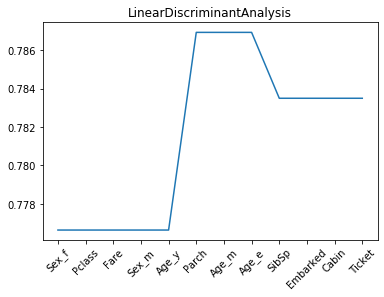

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import f1_score, accuracy_score
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


classifiers = [KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform'),
               
               XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1),

               LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False),

               RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
              max_depth=None, max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
              oob_score=False, random_state=None, verbose=0,
              warm_start=False),

               GaussianNB(priors=None, var_smoothing=1e-09),
               
               SVC(),
               
               LinearDiscriminantAnalysis()]


df_resultados = pd.DataFrame({'PassengerId': titanic_test['PassengerId']})



for clf in classifiers:

  x_axis = []
  y_axis = []

  for m in range(len(colunas)):
    n = 10
    accuracy_list = [] 
    f1_list = []

    for iter in range(n):
      
      
      clf.fit(x_train[colunas[0: m+1]], y_train)
      y_pred = clf.predict(x_test[colunas[0: m+1]])
      
      accuracy = accuracy_score(y_pred, y_test)
      accuracy_list.append(accuracy)
      
      f1 = f1_score(y_pred, y_test)
      f1_list.append(f1)

      
      dataframe = pd.DataFrame({iter: y_pred}, index= titanic_test.index)

      df_resultados = pd.concat([df_resultados, dataframe], axis= 1)

    y_axis.append(pd.Series(accuracy_list).mean())
    x_axis.append(colunas[m])


    
    
    accuracy_serie = pd.Series(accuracy_list).sort_values(ascending= True)
    f1_serie = pd.Series(f1_list).sort_values(ascending= True)


  df_resultados['Final'] = df_resultados.drop(['PassengerId'], axis= 1).mode(axis= 1)[0]
  df_resultados['Porcentagem'] = df_resultados.drop(['PassengerId'], axis= 1).mean(axis= 1)

  final_accuracy = accuracy_score(df_resultados['Final'], y_test)
  final_f1 = f1_score(df_resultados['Final'], y_test)


  print(clf, 2*'\n', final_accuracy, accuracy_serie.mean(), final_f1, f1_serie.min(), 2*'\n')

  plt.plot(x_axis, y_axis)
  plt.xticks(rotation= 45)
  plt.yticks()
  plt.title(str(clf).split('(')[0])
  plt.show()

In [19]:
pd.Series(df_resultados.columns).head(30)

0     PassengerId
1               0
2               1
3               2
4               3
5               4
6               5
7               6
8               7
9               8
10              9
11              0
12              1
13              2
14              3
15              4
16              5
17              6
18              7
19              8
20              9
21              0
22              1
23              2
24              3
25              4
26              5
27              6
28              7
29              8
dtype: object

## Stacking Technique

### Simple stacking classification

In [20]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
import numpy as np
import warnings

warnings.simplefilter('ignore')

clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
clf4 = LogisticRegression()
clf5 = SVC()
clf6 = LinearDiscriminantAnalysis()
xgb = XGBClassifier()
sclf = StackingClassifier(classifiers=[clf1, clf2, clf3, clf4, clf5, clf6], 
                          meta_classifier= xgb)

print('3-fold cross validation:\n')

for clf, label in zip([clf1, clf2, clf3, clf4, clf5, clf6, sclf], 
                      ['KNN', 
                       'Random Forest', 
                       'Naive Bayes',
                       'Logistic Regression',
                       'SVC',
                       'Linear Discr. An.',
                       'StackingClassifier']):

    scores = model_selection.cross_val_score(clf, x_train, y_train, 
                                              cv=8, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))

3-fold cross validation:

Accuracy: 0.64 (+/- 0.03) [KNN]
Accuracy: 0.77 (+/- 0.04) [Random Forest]
Accuracy: 0.78 (+/- 0.04) [Naive Bayes]
Accuracy: 0.78 (+/- 0.04) [Logistic Regression]
Accuracy: 0.64 (+/- 0.05) [SVC]
Accuracy: 0.80 (+/- 0.04) [Linear Discr. An.]
Accuracy: 0.64 (+/- 0.03) [StackingClassifier]


### Probabilities as meta-features

In [21]:
clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
lr = LogisticRegression()
sclf = StackingClassifier(classifiers=[clf1, clf2, clf3],
                          use_probas=True,
                          average_probas=False,
                          meta_classifier=lr)

print('3-fold cross validation:\n')

for clf, label in zip([clf1, clf2, clf3, sclf], 
                      ['KNN', 
                       'Random Forest', 
                       'Naive Bayes',
                       'StackingClassifier']):

    scores = model_selection.cross_val_score(clf, x_train, y_train, 
                                              cv=3, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" 

          % (scores.mean(), scores.std(), label))

3-fold cross validation:

Accuracy: 0.63 (+/- 0.01) [KNN]
Accuracy: 0.79 (+/- 0.03) [Random Forest]
Accuracy: 0.78 (+/- 0.02) [Naive Bayes]
Accuracy: 0.63 (+/- 0.01) [StackingClassifier]


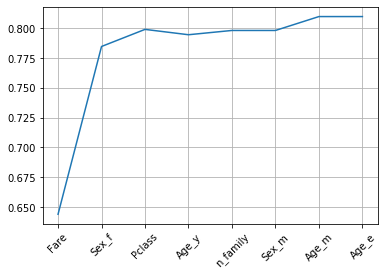

In [22]:
#colunas = ['Fare', 'Sex', 'Age', 'n_family', 'Parch', 'Embarked', 'Cabin', 'Ticket']
colunas = ['Fare', 'Sex_f', 'Pclass', 'Age_y', 'n_family', 'Sex_m', 'Age_m', 'Age_e']

iterations = 5

accuracy_list_ = []
f1_list_ = []

x_axis_ = []
y_axis_ac = []
y_axis_f1 = []

colunas_ = []

for feat in colunas:

  colunas_.append(feat)
  accuracy_list_ = []
  f1_list_ = []  
  
  for it in range(iterations):
         
    x_train_, x_test_, y_train_, y_test_ = train_test_split(titanic[colunas_], titanic['Survived'], test_size= 0.25, random_state= it)


    '''

    clf_ = LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                          solver='svd', store_covariance=False, tol=0.0001)

    '''

    clf_ = XGBClassifier()


    clf_.fit(x_train_, y_train_)
    y_pred_ = clf_.predict(x_test_)

    accuracy_list_.append(accuracy_score(y_pred_, y_test_))
    f1_list_.append(f1_score(y_pred_, y_test_))
    
  x_axis_.append(feat)
  y_axis_ac.append(pd.Series(accuracy_list_).mean())
  y_axis_f1.append(pd.Series(f1_list_).mean())

plt.plot(x_axis_, y_axis_ac)
plt.xticks(rotation= 45)
plt.grid()
plt.show()

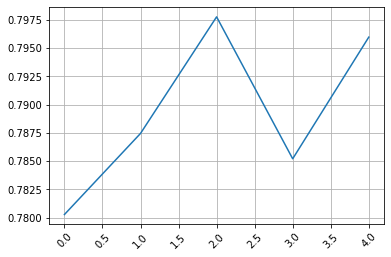

In [23]:
#colunas = ['Fare', 'Sex', 'Age', 'n_family', 'Parch', 'Embarked', 'Cabin', 'Ticket']
colunas = ['Fare', 'Sex_f', 'Pclass', 'n_family', 'Sex_m', 'Age_y', 'Age_m', 'Age_e']


df_resultados_ = pd.DataFrame({'PassengerId': titanic['PassengerId']})

iterations = 10
folds = 5

x_axis_ = []
y_axis_ac = []
y_axis_f1 = []

for fold in range(folds):
  
  accuracy_list_ = []
  f1_list_ = []
  

  for it in range(iterations):

    x_train_, x_test_, y_train_, y_test_ = train_test_split(titanic[colunas], titanic['Survived'], test_size= 0.25, random_state= fold*it)

    '''

    clf_ = LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None, solver='svd', store_covariance=False, tol=0.0001)
    
    

    clf_ = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
    
    clf_ = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

    '''

    clf_ = LinearDiscriminantAnalysis()
    

    clf_.fit(x_train_, y_train_)
    y_pred_ = clf_.predict(x_test_)

    accuracy_list_.append(accuracy_score(y_pred_, y_test_))
    f1_list_.append(f1_score(y_pred_, y_test_))
  
    dataframe_ = pd.DataFrame({it: y_pred_}, index= y_test_.index)
    df_resultados_ = pd.concat([df_resultados_, dataframe_], axis= 1)


  y_axis_ac.append(pd.Series(accuracy_list_).mean())
  y_axis_f1.append(pd.Series(f1_list_).mean())


x_axis_ = np.arange(0, folds)
  
plt.plot(x_axis_, y_axis_ac)
plt.xticks(rotation= 45)
plt.grid()
plt.show()



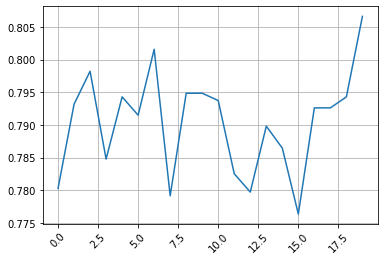

In [46]:
#colunas = ['Fare', 'Sex', 'Age', 'n_family', 'Parch', 'Embarked', 'Cabin', 'Ticket']
colunas = ['Fare', 'Sex_f', 'Pclass', 'n_family', 'Sex_m', 'Age_y', 'Age_m', 'Age_e']


df_resultados_ = pd.DataFrame({'PassengerId': titanic['PassengerId']})

iterations = 8
folds = 20

x_axis_ = []
y_axis_ac = []
y_axis_f1 = []

for fold in range(folds):
  
  accuracy_list_ = []
  f1_list_ = []
  

  for it in range(iterations):

    x_train_, x_test_, y_train_, y_test_ = train_test_split(titanic[colunas], titanic['Survived'], test_size= 0.25, random_state= fold*it)

    '''

    clf_ = LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None, solver='svd', store_covariance=False, tol=0.0001)
    
    

    clf_ = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
    
    clf_ = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

    '''

    clf_ = LinearDiscriminantAnalysis()
    

    clf_.fit(x_train_, y_train_)
    y_pred_ = clf_.predict(x_test_)

    accuracy_list_.append(accuracy_score(y_pred_, y_test_))
    f1_list_.append(f1_score(y_pred_, y_test_))
  
    dataframe_ = pd.DataFrame({it: y_pred_}, index= y_test_.index)
    df_resultados_ = pd.concat([df_resultados_, dataframe_], axis= 1)


  y_axis_ac.append(pd.Series(accuracy_list_).mean())
  y_axis_f1.append(pd.Series(f1_list_).mean())


x_axis_ = np.arange(0, folds)
  
plt.plot(x_axis_, y_axis_ac)
plt.xticks(rotation= 45)
plt.grid()
plt.show()



In [49]:
final = df_resultados_.mode(axis= 1)[0]
accuracy_score(final, titanic['Survived'])

0.7946127946127947

In [25]:
!git clone https://github.com/LeoFernanndes/functions

fatal: destination path 'functions' already exists and is not an empty directory.


In [26]:
from functions import squared
squared.squared_ab(1,2)

1

## References

Comprehensive data exploration with python

https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python

Stacked Regressions to predict House Prices

https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

A study on Regression applied to the Ames dataset

https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset

Handling imbalanced datasets in machine learning

https://towardsdatascience.com/handling-imbalanced-datasets-in-machine-learning-7a0e84220f28

Part II. Model Evaluation: Cross Validation, Bias and Variance Tradeoff and How to Diagnose Overfitting

https://medium.com/@karenovna.ak/part-ii-evaluating-a-predictive-model-cross-validation-and-bias-and-variance-tradeoff-9874b836cd2e

Scatterplots and correlation review

https://www.khanacademy.org/math/statistics-probability/describing-relationships-quantitative-data/introduction-to-scatterplots/a/scatterplots-and-correlation-review

Handling Categorical Data in Python

https://www.datacamp.com/community/tutorials/categorical-data
